In [1]:
%cd /home/ubuntu/repos/ix

/home/ubuntu/repos/ix


## Downloading data from S3

In [99]:
!mkdir -p data
!curl "https://data-science-v2.s3.amazonaws.com/all_nll.csv.gz" -o "data/all_nll.csv.gz"
!curl "https://data-science-v2.s3.amazonaws.com/lossess.csv" -o "data/lossess.csv"
!curl "https://data-science-v2.s3.amazonaws.com/no-missing-data.csv" -o "data/no-missing-data.csv"
!gunzip "data/all_nll.csv.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1212M  100 1212M    0     0  95.2M      0  0:00:12  0:00:12 --:--:-- 95.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8351  100  8351    0     0   153k      0 --:--:-- --:--:-- --:--:--  153k


# Monitoring Time Series

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display, TextDisplayObject, Markdown, Latex


In [3]:
# Flags
burnin = 2

In [4]:
# Data
df_nll = pd.read_csv('data/all_nll.csv')
df_loss = pd.read_csv("data/lossess.csv")
df_no_missing = pd.read_csv('data/no-missing-data.csv')
df_nll = df_nll.set_index(['idx', 'nans', 'deep', 'miss'])
df_nll = df_nll.sort_index()

## Lossess

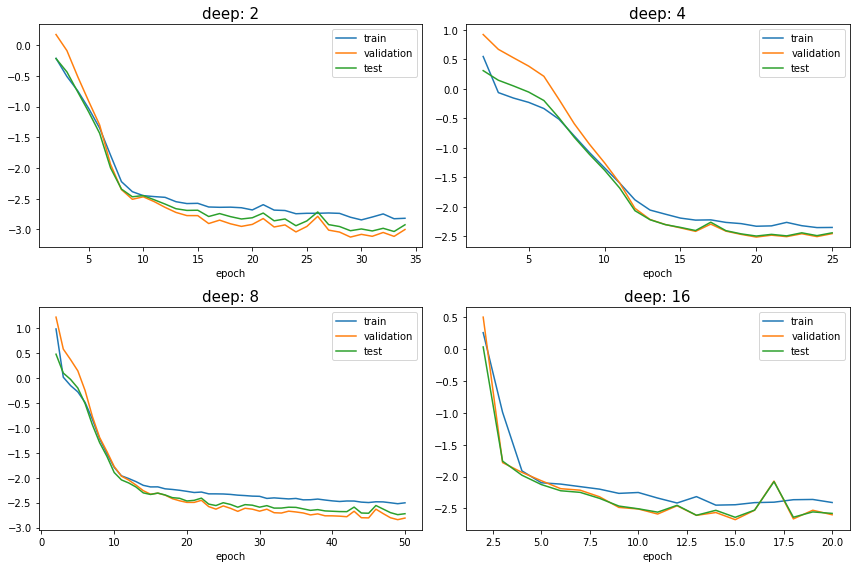

In [5]:
grouped = df_loss.loc[df_loss['epoch'] > 1].groupby("deep")
dims = (2,2)
fig, axs = plt.subplots(*dims, figsize=(12,8))
for (deep,df), ax in zip(grouped, axs.flatten()):
    df.plot(x='epoch', y=['train','validation','test'], ax=ax, title=f"deep: {deep}")
    ax.title.set_fontsize(15)
plt.tight_layout()

## NLL 

In [6]:
output = ""
tablespacing=10
tabel_styles = {
    'selector': 'caption',
    'props': [
        ('font-size', '20px')
    ]
}
nll = [c for c in df_nll.columns if 'nll' in c]
nll_df_ = df_nll.groupby(['nans', 'deep', 'miss'])[nll].mean().mean(axis=1).reset_index(drop=False)
for method, df in nll_df_.groupby('miss'):
    output += df.pivot_table(values=0, index='nans', columns='deep').style.set_table_attributes("style='display:inline'")\
        .set_caption(method).set_table_styles([tabel_styles])._repr_html_()
    output += tablespacing * "\xa0"
display(HTML(output))


deep,2,4,8,16
nans,,,,
5,-2.518932,-2.169222,-2.324952,-2.261265
10,-2.496050,-2.151268,-2.300165,-2.248365
15,-2.441728,-2.110451,-2.254963,-2.218176
20,-2.593584,-2.223778,-2.382331,-2.306832
deep,2,4,8,16
nans,,,,
5,-2.508215,-2.163930,-2.323438,-2.260711
10,-2.485124,-2.143158,-2.301747,-2.246541
15,-2.430634,-2.098874,-2.258537,-2.214722


## Prediction by Example

In [59]:
def draw_plot(adf, test_df, metric, nans, idx):
    mean = f"{metric}_mean"
    std = f"{metric}_std"
    _ = plt.clf()
    fig, axs = plt.subplots(4, 3,figsize=(15, 9),constrained_layout=True)
    x = adf.index.values
    y = test_df.loc[(idx,nans,2,'distribution'),metric].values

    # --------------------------------------------------------------------

    # deep 2 
    
    ## distribution
    y_est = test_df.loc[(idx,nans,2,'distribution'),mean].values
    y_err = test_df.loc[(idx,nans,2,'distribution'),std].values

    axs[0][0].plot(x, y_est, '-')
    axs[0][0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[0][0].plot(x, y, '-', color='tab:brown')

    ## mean
    y_est = test_df.loc[(idx,nans,2,'mean'),mean].values
    y_err = test_df.loc[(idx,nans,2,'mean'),std].values

    axs[0][1].plot(x, y_est, '-')
    axs[0][1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[0][1].plot(x, y, '-', color='tab:brown')

    ## sampling 
    y_est = test_df.loc[(idx,nans,2,'sampling'),mean].values
    y_err = test_df.loc[(idx,nans,2,'sampling'),std].values

    axs[0][2].plot(x, y_est, '-')
    axs[0][2].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[0][2].plot(x, y, '-', color='tab:brown')

    # -------------------------------------------------------------------

    # deep 4 

    ## distribution
    y_est = test_df.loc[(idx,nans,4,'distribution'),mean].values
    y_err = test_df.loc[(idx,nans,4,'distribution'),std].values

    axs[1][0].plot(x, y_est, '-')
    axs[1][0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[1][0].plot(x, y, '-', color='tab:brown')

    ## mean
    y_est = test_df.loc[(idx,nans,4,'mean'),mean].values
    y_err = test_df.loc[(idx,nans,4,'mean'),std].values

    axs[1][1].plot(x, y_est, '-')
    axs[1][1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[1][1].plot(x, y, '-', color='tab:brown')

    ## sampling 
    y_est = test_df.loc[(idx,nans,4,'sampling'),mean].values
    y_err = test_df.loc[(idx,nans,4,'sampling'),std].values

    axs[1][2].plot(x, y_est, '-')
    axs[1][2].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[1][2].plot(x, y, '-', color='tab:brown')


    # -------------------------------------------------------------------

    # deep 8

    ## distribution
    y_est = test_df.loc[(idx,nans,8,'distribution'),mean].values
    y_err = test_df.loc[(idx,nans,8,'distribution'),std].values

    axs[2][0].plot(x, y_est, '-')
    axs[2][0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[2][0].plot(x, y, '-', color='tab:brown')

    ## mean
    y_est = test_df.loc[(idx,nans,8,'mean'),mean].values
    y_err = test_df.loc[(idx,nans,8,'mean'),std].values

    axs[2][1].plot(x, y_est, '-')
    axs[2][1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[2][1].plot(x, y, '-', color='tab:brown')

    ## sampling 
    y_est = test_df.loc[(idx,nans,8,'sampling'),mean].values
    y_err = test_df.loc[(idx,nans,8,'sampling'),std].values

    axs[2][2].plot(x, y_est, '-')
    axs[2][2].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[2][2].plot(x, y, '-', color='tab:brown')


    # -------------------------------------------------------------------

    # deep 16

    ## distribution
    y_est = test_df.loc[(idx,nans,16,'distribution'),mean].values
    y_err = test_df.loc[(idx,nans,16,'distribution'),std].values

    axs[3][0].plot(x, y_est, '-')
    axs[3][0].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[3][0].plot(x, y, '-', color='tab:brown')

    ## mean
    y_est = test_df.loc[(idx,nans,16,'mean'),mean].values
    y_err = test_df.loc[(idx,nans,16,'mean'),std].values

    axs[3][1].plot(x, y_est, '-')
    axs[3][1].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[3][1].plot(x, y, '-', color='tab:brown')

    ## sampling 
    y_est = test_df.loc[(idx,nans,16,'sampling'),mean].values
    y_err = test_df.loc[(idx,nans,16,'sampling'),std].values

    axs[3][2].plot(x, y_est, '-')
    axs[3][2].fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    axs[3][2].plot(x, y, '-', color='tab:brown')

    
    
    # ----------------------------------------------------------------
    # titles 

    fig.suptitle(f"{metric}- {nans}% missing datapoint- idx: {idx}", fontsize=16)

    ## columns distribution mean sampling
    axs[0][0].set_title('distribution')
    axs[0][1].set_title('mean')
    axs[0][2].set_title('sampling')

    ## rows 
    axs[0][0].set_ylabel("deep-2", rotation=0, size='large', labelpad=40)
    axs[1][0].set_ylabel("deep-4", rotation=0, size='large', labelpad=40)
    axs[2][0].set_ylabel("deep-8", rotation=0, size='large', labelpad=40)
    axs[3][0].set_ylabel("deep-16", rotation=0, size='large', labelpad=40)


    _ = plt.show()

In [55]:
idx = 6672

<Figure size 432x288 with 0 Axes>

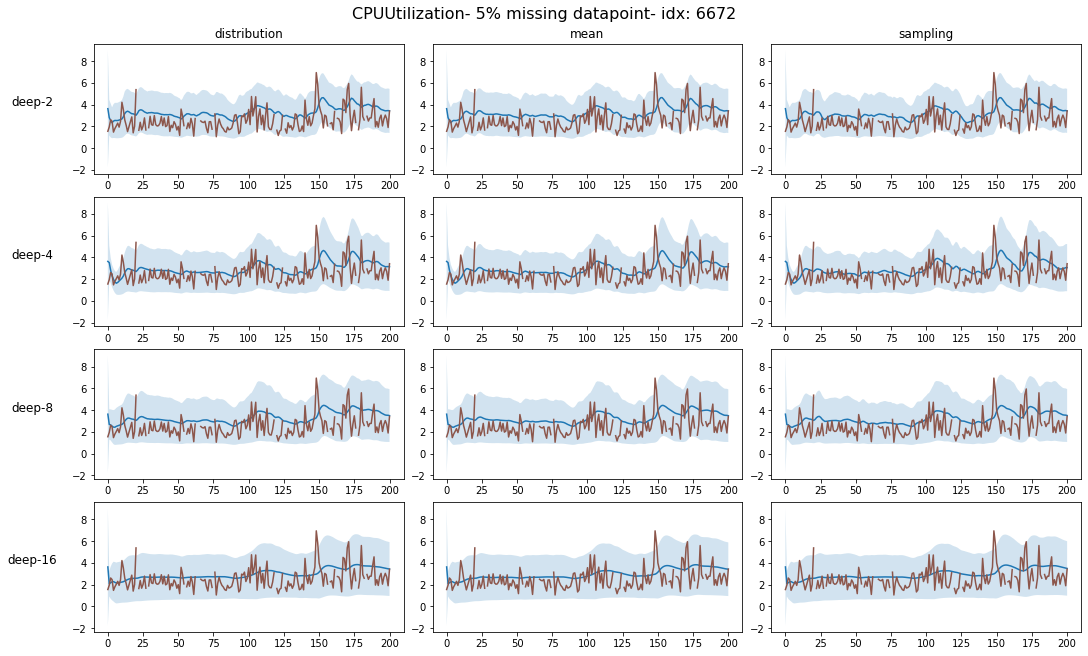

<Figure size 432x288 with 0 Axes>

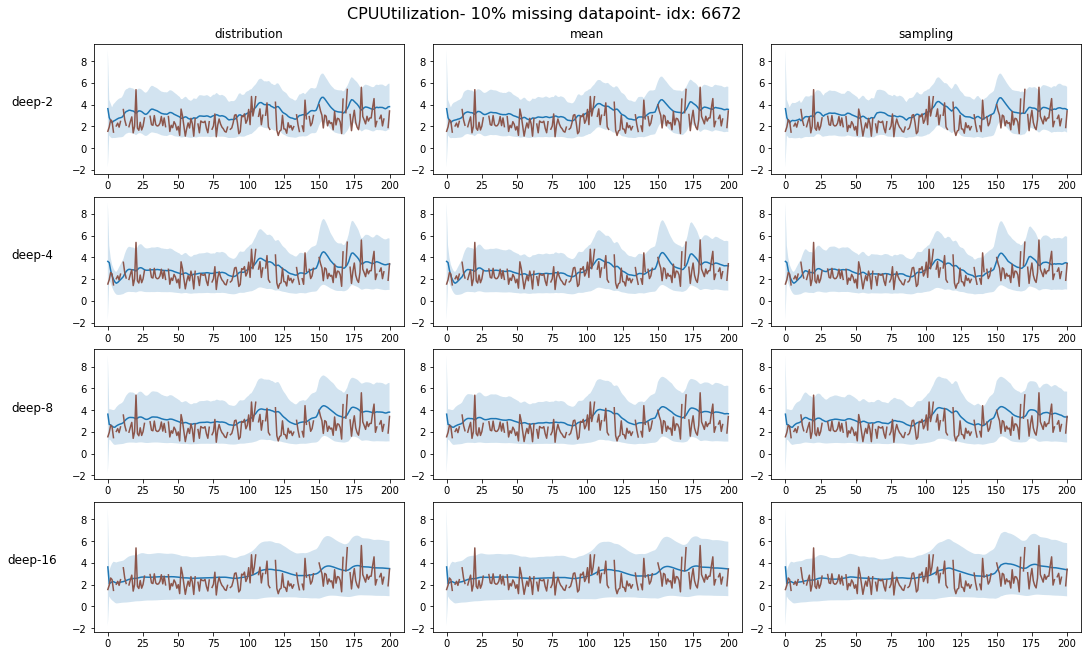

<Figure size 432x288 with 0 Axes>

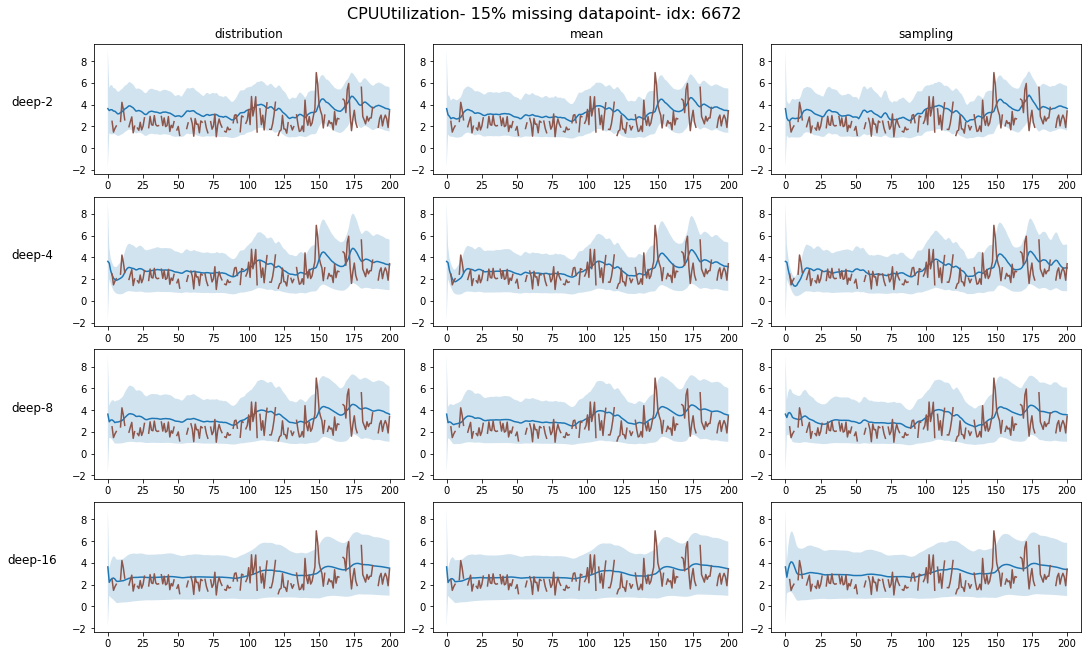

<Figure size 432x288 with 0 Axes>

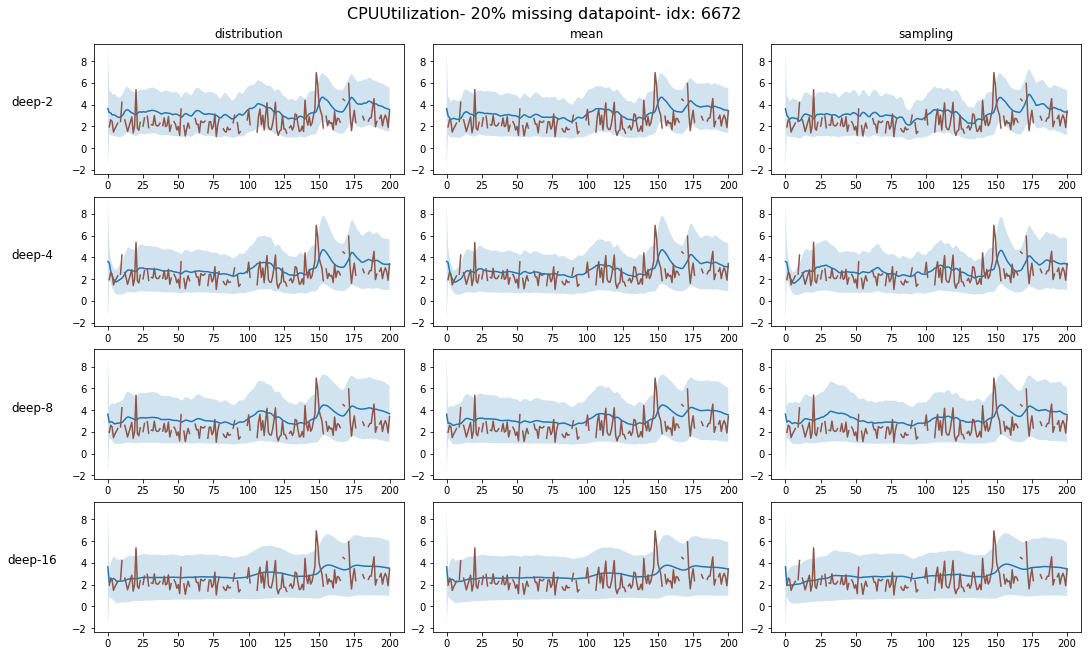

In [60]:
for nans in [5,10,15,20]:
    draw_plot(df_no_missing, df_nll, "CPUUtilization", nans, idx)